In [1]:
## Python Libraries
import pandas as pd
from pandasql import sqldf
from functools import reduce
import chart_studio.plotly as ply
from chart_studio.plotly import plot_mpl
from statsmodels.tsa.seasonal import seasonal_decompose
import cufflinks as cf
import warnings
warnings.filterwarnings("ignore")
import joblib
import matplotlib.pyplot as plt

#import statsmodels.api as sm
#plt.figure(figsize=(25,25))

In [2]:
## We follow python microservices architecture

## Data Read Service
## Data Pre-processing Service
## Data Load to Cassandra
## Model Building Service
## Forecasting Service
## Save Data to Cassandra
## Dockerize the Solution 
## Add Kubernetes

In [3]:
DATA_FILE = '/Users/kaustavsaha/startup_project/Data.csv'

In [4]:
def data_read(data_path):
    data = pd.read_csv(data_path)
    df   = pd.DataFrame(data)
    print(' #### Initial Data Load ####')
    print(df.head(5))
    return df

In [5]:
def basic_data_structure_exploration(df):
    print('#########  Data Shape  #########')
    print(df.shape)
    print('#########  Data Head   ##########')
    print(df.head())
    print('#########  Data Types   ##########')
    print(df.dtypes)
    print('######### Day Type Values ########')
    print(df.daytype.unique())
    print('########  Total number of NaN  ######')
    print(df.isna().sum())
    print('######### Unique Station Id #######')
    print(df.station_id.nunique())
    print('########  Unique Station Name  ######')
    print(df.stationname.nunique())

In [6]:
def date_time_feature_extractor(date,n):
    date_str      = str(date)
    date_str_list = date_str.split('/')
    data_parser   = int(date_str_list[n])
    return(data_parser)

In [7]:
def data_augmentation(df):
    df['Month'] = df.date.apply(lambda x : date_time_feature_extractor(x,0))
    df['Day']   = df.date.apply(lambda x : date_time_feature_extractor(x,1))
    df['Year']  = df.date.apply(lambda x : date_time_feature_extractor(x,2))
    print('#####   Augmented Data  ########')
    print(df.head(5))
    return(df)

In [8]:
## TODO 
## def extra_visualization(df):
## Extra Visualization 
## X axis is Years
## Y axis is Box plot of Total Rides by station-ids 

In [9]:
## Station Count Across Years
def station_name_count(df):
    df_station_count  = pd.DataFrame(df.groupby('Year').station_id.nunique())
    df_station_count.plot(kind = 'bar', ylim = (140,146) , title = 'Total Number of Stations across years')

In [10]:
def total_rides_across_years(df):
    df_year_rides  = pd.DataFrame(df.groupby('Year')['rides'].sum())
    df_year_rides.plot(kind = 'bar', title = 'Total Rides in millions across years')

In [11]:
def top_total_rides_across_stations(df):
    total_station_rides  = pd.DataFrame(df.groupby('station_id')['rides'].sum())
    total_station_rides    = total_station_rides.sort_values('rides', ascending = False)
    top_station_rides = total_station_rides.head(10)
    print(top_station_rides)
    top_station_rides.plot(kind = 'bar', ylim = (50000000, 100000000) , title = 'Top Stations with Total Rides (millions)')
    
    

## TODO
## Change station_id -> station_name
'''
query_full_ride = """ select  , count(*) as total_rides
                      from df 
                      group by 1,2
                      order by total_rides desc
                  """

pysqldf_query_full_ride = lambda query_full_ride : sqldf(query_full_ride, globals())

df_full_ride = pysqldf_query_full_ride(query_full_ride)

df_full_ride
'''
####

'\nquery_full_ride = """ select  , count(*) as total_rides\n                      from df \n                      group by 1,2\n                      order by total_rides desc\n                  """\n\npysqldf_query_full_ride = lambda query_full_ride : sqldf(query_full_ride, globals())\n\ndf_full_ride = pysqldf_query_full_ride(query_full_ride)\n\ndf_full_ride\n'

In [12]:
def basic_data_visualization(df):
    total_rides_across_years(df)
    top_total_rides_across_stations(df)
    station_name_count(df)

In [13]:
def custom_count_func(series):
    return reduce(lambda x, y : y + int(x == 0),series)
    #####
    ### return reduce(lambda x, y : y + int(x == (x == 0)),series)

In [14]:
def zero_ride_analysis(df):
    
    ## Overall
    print('##########################################')
    print('###### Stations,Daytype with zero ridership that cannot be used for Time-Series Modelling') 
    station_daytype  = pd.DataFrame(df.groupby(['station_id','daytype'])['rides'].agg('sum'))
    print(station_daytype.query('rides == 0'))
     
    ## Individual
    ## Number of zero ride days individual station_id,daytype 
    ## HACK -> Use Aggregate Function
    ## x = pd.DataFrame(df.groupby(['station_id','daytype']).agg({'rides':['count',custom_count_func]})
    ## print(x)

In [15]:
## Missing Data Replacement with Last 4 Weeks average for that day 
## If there are zeroes in the last 4 weeks then divide by existing number of elements
## For holidays average of that month in the previous year

def Imputation(model_data):
    print(model_data.rides.isin([0]).sum())
    #print(model_data.loc[model_data['rides'] == 0])

In [16]:
def model_data_creator(df):

    Model_Data_Repository = {}
    
    model_exclusion = []
    total_models    = []

    total_num_models = df.groupby(['station_id','daytype']).sum().reset_index()
    total_num_models = total_num_models.drop(['Day','Month','Year'], axis = 1)

    zero_ride_station = total_num_models.query('rides == 0')

    for index, row in zero_ride_station.iterrows():
        station_id = row['station_id']
        daytype    = row['daytype']
        model_name = str(row['station_id']) + '_' + str(row['daytype'])
        model_exclusion.append(model_name)

    for index, row in total_num_models.iterrows():
        station_id = row['station_id']
        daytype    = row['daytype']
        model_name = str(row['station_id']) + '_' + str(row['daytype'])
        total_models.append(model_name)

    total_models = [x for x in total_models if x not in model_exclusion]

    for individual_model in total_models :
        lst = individual_model.split('_')
        station_id = int(lst[0])
        daytype    = str(lst[1])
        model_data = df[(df['station_id'] == station_id) & (df['daytype'] == daytype)]
        model_data = model_data.sort_values(by=['Year','Month','Day'])
        model_data = model_data[['date','rides']]
        model_data.index = pd.to_datetime(model_data.index)
        Model_Data_Repository[individual_model] = model_data
    
 
    for individual_model, model_data in Model_Data_Repository.items():
        Imputation(model_data)

In [17]:
def data_pre_processing(df):
    zero_ride_analysis(df)
    model_data_creator(df)


In [18]:
#def split_data_train_test(df):
    

In [19]:
#  Modelling the holidays
## unevenly spaced out events hence 
## there might be a lack of cyclycity of time series as public holidays 
## will differ from year to year. These are essentially random processes (point process)

## Variations in a Time Series is composed of trend, seasonality, cyclicity and noise

## Use of ARIMA
## p -> Parameter capturing Auto-Regressive aspect of the model. 
##      event dependency from past to present

## d -> Parameter capturing integrated portion of the 
##      model - amount of differencing applied to a time-series


## Use of SARIMA
## P,D,Q corresponding parameters for seasonal components of the model

## For the sake of simplicity we will consider uni-variate time series rides -> time
##### Modelling
def modelling(df):
    #df.iplot(title = 'Time Series Plot between 2000 and 2017')

    ## Additive Model       -> Trend is approx linear and seasonality is approx constant over time
    ## Multiplicative Model -> Increasing / Decreasing at a non-linear rate

    result = seasonal_decompose(df, model='multiplicative')
    fig = result.plot()
    plot_mpl(fig)
    
    
## Grid Search over multiple values of p,d,q,P,D,Q using AIC (Akaike Information Criterion) 
## which estimates relative quality of statistical model. From a group of models AIC estimates
## quality of each model relative to each of the other models. Lower AIC score dictates choice
## of model - Better fitted model with fewer features ranked higher over similar models with more features

In [18]:
def save_model(model, model_filename):
    
    ## Save Model to Disk
    model_filename = model_filename + '.sav'
    joblib.dump(model,model_filename)

In [19]:
def load_model(model_filename):
    
    ## Load Model from disk
    model_filename = model_filename + '.sav'
    model = joblib.load(model_filename)
    
    return(model)

In [20]:
def driver_function():
    
    ## Service for Data Reading
    df = data_read(DATA_FILE)
    
    ## Service for Data Augmentation
    df           = data_augmentation(df)
    
    ## Service for Basic Analysis of Data Structure
    basic_data_structure_exploration(df)
    
    ## Service for Basic Data Visualization
    basic_data_visualization(df)
    
    ## Service for Data Imputation
    data_pre_processing(df)
    
    #train_df , test_df = split_data_train_test(df)
    
    ## Service for Modelling
    #modelling(df)
    

 #### Initial Data Load ####
   station_id       stationname        date daytype  rides
0       40850           Library  10/09/2004       A   1057
1       40780      Central Park  06/18/2010       W   1154
2       41500    Montrose-Brown  10/30/2001       W   2116
3       40500  Washington/State  10/26/2006       W      0
4       41090      Monroe/State  07/07/2010       W   9431
#####   Augmented Data  ########
   station_id       stationname        date daytype  rides  Month  Day  Year
0       40850           Library  10/09/2004       A   1057     10    9  2004
1       40780      Central Park  06/18/2010       W   1154      6   18  2010
2       41500    Montrose-Brown  10/30/2001       W   2116     10   30  2001
3       40500  Washington/State  10/26/2006       W      0     10   26  2006
4       41090      Monroe/State  07/07/2010       W   9431      7    7  2010
#########  Data Shape  #########
(988858, 8)
#########  Data Head   ##########
   station_id       stationname        date

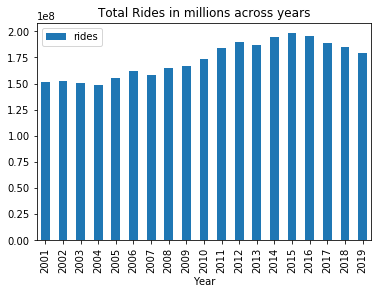

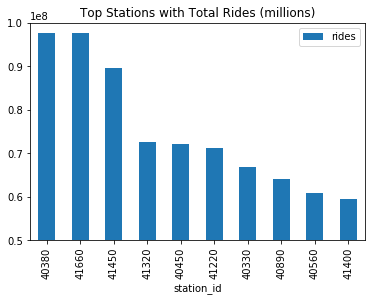

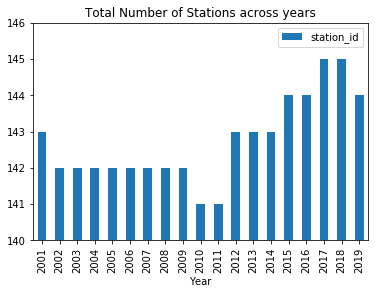

In [21]:
## Triggering Point
driver_function()

In [21]:
## Find out total number of unique stations 
## (distinct station_id, station_name) across the years (2001-2016)
## We have to perform Time Series Analysis on each of these time series 
## Each model in the family of models will be stationid_daytype

In [22]:
## Using joblib -> part of the scipy 
## ecosystem that provides utilities for pipelining python jobs
## Utilities for saving and loading python objects that make
## use of numpy data structures efficiently

In [24]:
## XGBoost Model
## Feature Creation for XGBoost
## Feature-Set
## Response is (t+7)
## 1.  Average of (t-7)
## 2.  Average of (t-14)
## 3.  Average of (t-21)
## 4.  Average of (t-28)
## 5.  std of (t-7)
## 6.  std of (t-14)
## 7.  std of (t-21)
## 8.  std of (t-28)
## 9.  median of (t-7)
## 10. median of (t-14)
## 11. median of (t-21)
## 12. median of (t-28)
## 13. Day of month 
## 14. Month
## 15. Weekend
## 16. Holiday

## Evaluation Criteria
## RMSE
## MAPE

In [25]:
## Time-Series Model
## RMSE
## MAPE

### Data Pre-Processing
# 1. Full Model
# 2. Tri-furcated Model
# 3. Holiday 


In [26]:
## Imputation

## Algorithm 
## 1. Find out timestamps which have zero values in the time series
## 2. Impute by average of rides in the past 4 weeks
